# Conditional, observed conditional, and predictive power

## Preliminaries

In [ ]:
import Pkg; Pkg.activate("..")
import QuadGK
using Distributions, Zygote, JuMP, Ipopt, DataFrames

# want to plot in R
using RCall
RCall.rcall_p(:options, rcalljl_options=Dict(:width => 800, :height => 400))
@rlibrary ggplot2
R"
library(tidyverse)
library(patchwork)
"

In [2]:
# Gauss quadrature pivots and weights
ξ, ω = QuadGK.gauss(50)
# rule for interval [a, b]
integrate(f, a, b) = (b-a)/2 * sum(ω.*f.((b-a)/2 .* ξ .+ (a + b)/2))
# rule for interval [a, Inf)
function integrate(f, a)
    g(t) = f.(a .+ t ./ (1 .- t)) ./ (1 .- t).^2
    integrate(g, 0, 1)
end
# rule for interval (-Inf, a]
function integrate2(f, a)
    g(t) = f.(a .- (1 - t) ./ t) ./ t.^2
    integrate(g, 0, 1)
end
# rule for interval (-Inf, Inf)
function integrate(f)
    g(t) = f.(t ./ (1 .- t.^2)) .* (1 .+ t.^2) ./ (1 .- t.^2).^2
    integrate(g, -1, 1)
end

integrate (generic function with 3 methods)

$$
\newcommand{\Pr}{\operatorname{Pr}}
\newcommand{\CP}{\operatorname{CP}}
\newcommand{\OCP}{\operatorname{OCP}}
\newcommand{\PP}{\operatorname{PP}}
\newcommand{\PoS}{\operatorname{PoS}}
\newcommand{\crit}{z_{1-\alpha}}
\newcommand{\cond}{\,|\,}
$$

## Clinical trial example: initial sample size

We consider a single arm superiority trial to test $\mathcal{H}_0:\theta\leq 0$ based on the test statistic

$$
Z_n := \frac{1}{\sigma\sqrt{n}}\sum_{i=1}^n X_i, \quad \operatorname{E}[\,X_i\,] = \theta, \operatorname{V}[\,X_i\,] = \sigma^2<\infty
$$

for independent and identically distributed $X_i$. 
All following considerations can easily be generalised to the practically more relevant two-arm superiority case. 
We merely discuss the singlea-arm case for the sake of simplicity in terms of notation.
The test statistic is asymptotically normal

$$
Z_n\stackrel{\cdot}{\sim}\mathcal{N}(\sqrt{n}\,\theta, 1) \ .
$$

We further assume that there is vague prior information that can be summarized in a normal prior

$$
\varphi(\theta) = \phi\left(\frac{\theta - 0.4}{0.2}\right)
$$

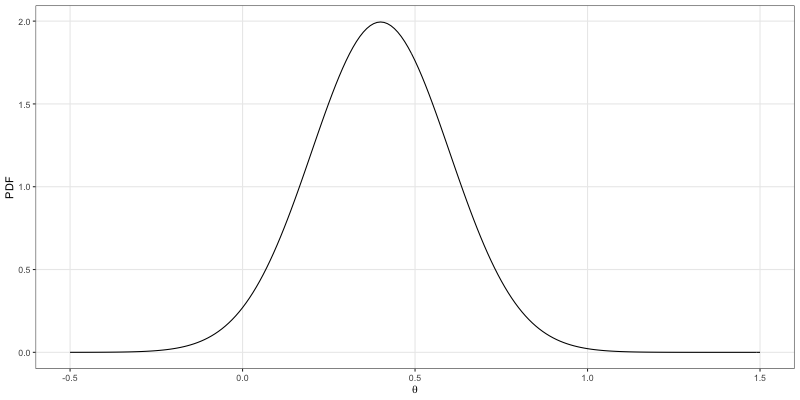

RObject{VecSxp}


In [3]:
φ(θ) = pdf(Normal(0.4, 0.2), θ)
   θ = collect(-0.5:0.01:1.5)

tbl_priors = DataFrame(
     theta = θ,
    normal = φ.(θ)
)

@rput tbl_priors
R"tbl_priors <- pivot_longer(tbl_priors, -theta, names_to = 'prior')"
tbl_priors = @rget tbl_priors

R"ggplot($tbl_priors) +
    aes(theta, value) +
    geom_line() +
    theme_bw() + 
    labs(x = expression(theta), y = 'PDF') +
    theme(
        legend.position = 'top',
        panel.grid.minor = element_blank()
    )"

In [4]:
ggsave("prior-density.pdf", width = 8, height = 4)

RObject{NilSxp}
NULL


To dermine the sample size $n$, we assume that the maximal acceptable type one error rate is $\alpha=0.025$ and an expected power [???] of $1-\beta=0.8$ is targeted.

In [5]:
   α = 0.025
crit = quantile(Normal(), 1 - α)

function EP(n, prior) 
         norm = integrate(prior, 0)
    cprior(θ) = prior(θ)/norm
    integrate(θ -> (1 - cdf(Normal(√(n)*θ, 1), crit))*cprior(θ), 0)
end

EP (generic function with 1 method)

In [6]:
EP.(78:80, φ)

3-element Array{Float64,1}:
 0.7987500275424192
 0.8009620001458296
 0.8031249392161792

A sample size of $n = 79$ is sufficient to fulfill both error rate constraints. 

In [7]:
n = 79 

79

## Unplanned interim analyses

We now consider a situation where - for whatever reason - an unblinded interim analysis is conducted after $m=26$ outcomes have been observed. 

[todo: how is that usually justified?]

The sponsor then wants to reassess the prospects of successfully rejecting the null hypothesis at the end if the trial. Mainly four quantities are discussed in the literature in this context. 

In [8]:
m = 26

26

### Conditional power

We define conditional power as the probability to ultimately reject the
null hypothesis when $m < n$ outcomes are observed where $n$ is the final sample size

\begin{align}
\CP(z_m, \crit, \theta) :&= \Pr_\theta[\,Z_n > \crit \cond Z_m = z_m\,] \\
    &= 1 - \Phi\left(
            \frac{\crit - \sqrt{n}\,\theta - \sqrt{\tau} \, z_m + \sqrt{m}\,\theta
            }{\sqrt{1 - \tau}}
        \right) \ .
\end{align}

In [9]:
function CP(zm, n, m, c, θ)
    τ = m/n
    if τ >= 1
        return 0.0
    end
    μ = √(n)*θ + √(τ)*(zm - √(m)*θ)
    σ = √(1 - τ)
    1 - cdf(Normal(μ, σ), c)
end

CP (generic function with 1 method)

Note that the expression $\CP(z_m, \crit, \theta)$ depends on the unknown effect size $\theta$. 
Often the sample size $n$ is not based on expected power but simply the power at a point alternative $\theta_1>0$.
Conditional power is then often used to synomously refer to $\CP(z_m, \crit, \theta_1)$ where the unknown effect size is simply replaced with the effect size underlying the sample size calculation. 
Although we derived $n$ using predictive power and the prior density $\varphi(\cdot)$, we can mimmic the process by plugging in the prior mean, $0.4$.
To make the distinction between $\CP(z_m, \crit, \theta)$ and $\CP(z_m, \crit, \theta_1)$ explicit, we refer to the latter one as 'assumed conditional power' or ACP. 

### Observed conditional power

An alternative approach sometimes cited in the literature [The reassessment of trial perspectives from interimdata—a critical view] is to use the
maximum likelihood estimator for $\theta$, $\widehat{\theta}(z_m):=z_m/\sqrt{m}$, as plug-in.
We then define observed conditional power as
$$
\OCP(z_m, \crit) := \CP\big(z_m, \crit, \widehat{\theta}(z_m)\big) \ .
$$

In [10]:
OCP(zm, n, m, c) = CP(zm, n, m, c, zm/sqrt(m))

OCP (generic function with 1 method)

### Predictive power

A more principled approach is given by simply conditioning expected power on the observed interim outcome $Z_m = z_m$.
This quantity has been termed predictive power in the literature although 'conditional expected power' might be a more fitting term. 
In contrast to most previous authors [???] we are consistent with [our paper] and conditiona on $\Theta>0$. 
Predictive power is thus defined as

\begin{align}
    \PP(z_m,\crit) :\!\!&= \Pr[\,Z_n > c \cond \Theta >0, Z_m = z_m\,] \\
    &= \int_{0}^{\infty}\CP(z_m, \crit, \theta)\,\frac{\varphi(\theta\cond Z_m=z_m)}{\Pr[\,\Theta\geq0\cond Z_m=z_n\,]}\operatorname{d}\theta \ .
\end{align}

In [11]:
function posterior(θ, zm, m, prior)
                 prop(θ) = pdf(Normal(√(m)*θ, 1), zm) * prior(θ)
    normalising_constant = integrate(prop)
    prop(θ) / normalising_constant
end

function cposterior(θ, zm, m, prior)
    # condition prior on effect > 0
    normalizing_constant = integrate(prior, 0)
               cprior(θ) = prior(θ) / normalizing_constant
                 prop(θ) = pdf(Normal(√(m)*θ, 1), zm) * cprior(θ)
    normalising_constant = integrate(prop, 0)
    prop(θ) / normalising_constant
end

PP(zm, n, m, c, prior) = integrate(θ -> CP.(zm, n, m, c, θ) * cposterior.(θ, zm, m, prior), 0)

PP (generic function with 1 method)

### Conditional probability of success

A quantity closely related to predictive power is the conditional probability of success.
The relation is the same as for the unconditional quantities expected power and probability of success [our paper].
Note that we define probability of success as joint probability of rejection and positive effect, i.e.

\begin{align}
\PoS(\crit\cond z_m) :&= \Pr[\,Z_n > \crit, \Theta >0\cond Z_m = z_m\,] \\
                      &= \Pr[\,\Theta >0\cond Z_m = z_m\,] \, \PP(z_m, \crit) \ .
\end{align}

In [12]:
cPoS(zm, n, m, c, prior) = integrate(θ -> CP.(zm, n, m, c, θ) * posterior.(θ, zm, m, prior), 0)

cPoS (generic function with 1 method)

## Comparing conditional-, observed-, predictive power, and conditional probability of success

The previous example makes a strong case for using predictive power to measure the interim prospects of rejecting the null hypothesis at the end of the study. In short, 
* predictive power directly relates to (unconditional) expected power [cite our paper] which is an attractive unconditional measure to generalise frequentist power (and sample size derivation) under uncertainty; in fact, predictive power is just expected power conditioned on the interim results.
* predictive power directly relates to the conditional probability of success; using it thus facilitates consistent discussion of early-futility stopping which should be based on the joint probability of a positive effect and its detection conditional on the interim data (condition probability of success).
* predictive power is actually a generalisation of conditional power; conditional power can be seen as a special case with a point prior on $\theta_1$; this shows that the use of conditional power implicitly makes strong assumptions.

We now compare the three quantities in more detail.
Firstly, we can assess how they change as functions of the interm observed outcome. To this end we slighlyt extend the range of $z_m$-values beyond the interesting range where a sample size reassessment could be considered.

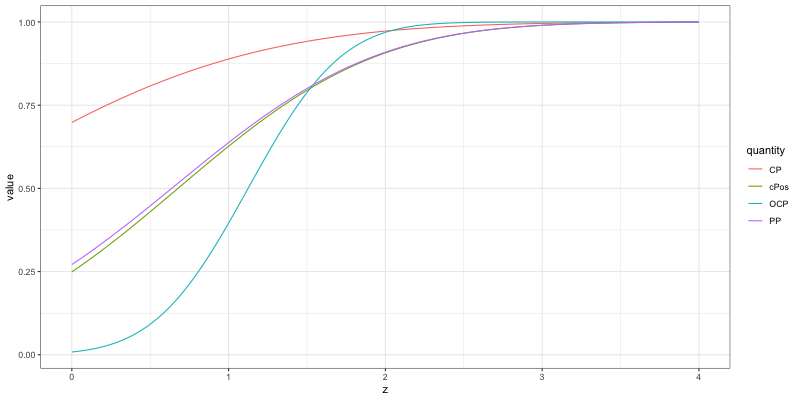

RObject{VecSxp}


In [13]:
zm = 0:0.005:4

tbl_absolute = DataFrame(
      z = zm,
     CP = CP.(zm, n, m, crit, 0.4),
    OCP = OCP.(zm, n, m, crit),
     PP = PP.(zm, n, m, crit, φ),
   cPos = cPoS.(zm, n, m, crit, φ)
)

@rput tbl_absolute
R"tbl_absolute <- pivot_longer(tbl_absolute, -z, names_to = 'quantity')"
tbl_absolute = @rget tbl_absolute

ggplot(tbl_absolute) +
    aes(:z, :value, color = :quantity) +
    geom_line() +
    theme_bw()

Clearly, OCP is the most sensitive measure while CP is the least sensitive. Intuitively, this should be clear since CP assumes a fixed effect size and is this only directly affected by changes in $z_m$ whereas OCP and PP are also indireclty affected by updating the belief about the true effect size with the interim results. 
PP does so in a principled way by invoking Bayes theorem. The degree of adaptation depends on the vagueness of the prior. The plug-in estimate OCP simply assumes that the observed effect is the true effect. The latter ignores any sampling uncertainy about the observed effect and is not justified theoretically.
The conditional PoS is very similar to PP since the posterio probability of a non-null effect is almost 1. Note that the two are *not* proportional due to the Bayesian updating of the prior and thus the factor $\Pr[\,\Theta >0\cond Z_m = z_m\,]$ not being constant in $z_m$.

To make this distinction (see als ... certainly discussed at length before) more tangible, we can decompose the variability of the respecitve measures with respect to changes in $z_m$ into the indirect variability due to changes in assumptions about $\theta$ and direct variability due to changes in $z_m$.

[chain rule]

In [14]:
∇2posterior(θ, zm, m, prior) = gradient(zm -> posterior(θ, zm, m, prior), zm)[1]
∇2cposterior(θ, zm, m, prior) = gradient(zm -> cposterior(θ, zm, m, prior), zm)[1]


∇1CP(zm, n, m, c, θ) = gradient(zm ->  CP(zm, n, m, c, θ), zm)[1]
∇2CP(zm, n, m, c, θ) = gradient(θ ->  CP(zm, n, m, c, θ), θ)[1]

OCP(zm, n, m, c) = CP(zm, n, m, c, zm/sqrt(m))
∇OCP(zm, n, m, c) = gradient(zm -> OCP(zm, n, m, c), zm)[1]


function ∇1PP(zm, n, m, c, prior)
    f(θ) = ∇1CP.(zm, n, m, c, θ) * cposterior.(θ, zm, m, prior)
    integrate(f, 0)
end
function ∇2PP(zm, n, m, c, prior)
    f(θ) = CP.(zm, n, m, c, θ) * ∇2cposterior.(θ, zm, m, prior)
    integrate(f, 0)
end

function ∇1cPoS(zm, n, m, c, prior)
    f(θ) = ∇1CP.(zm, n, m, c, θ) * posterior.(θ, zm, m, prior)
    integrate(f, 0)
end
function ∇2cPoS(zm, n, m, c, prior)
    f(θ) = CP.(zm, n, m, c, θ) * ∇2posterior.(θ, zm, m, prior)
    integrate(f, 0)
end

∇2cPoS (generic function with 1 method)

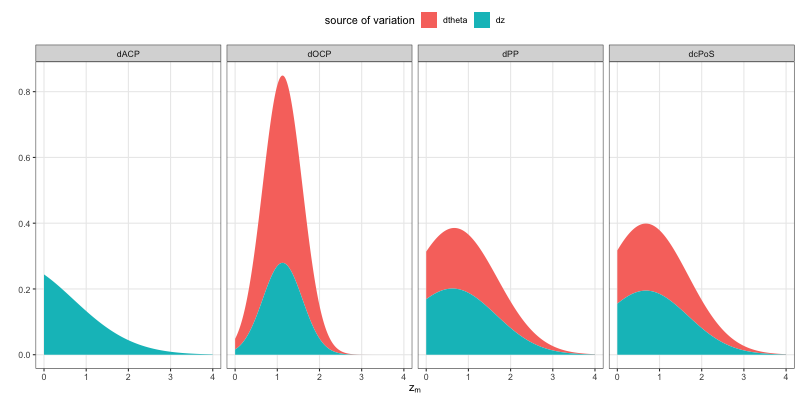

RObject{VecSxp}


In [15]:
zm = 0:0.005:4

tbl = DataFrame(
            zm = zm,
        dACP_dz = ∇1CP.(zm, n, m, crit, 0.4),
        dOCP_dz = ∇1CP.(zm, n, m, crit, zm ./ sqrt(m)),
         dPP_dz = ∇1PP.(zm, n, m, crit, φ),
    dOCP_dtheta = ∇2CP.(zm, n, m, crit, zm ./ sqrt(m)) ./ sqrt(m),
     dPP_dtheta = ∇2PP.(zm, n, m, crit, φ),
       dcPoS_dz = ∇1cPoS.(zm, n, m, crit, φ),
   dcPoS_dtheta = ∇2cPoS.(zm, n, m, crit, φ)
)

R"
$tbl %>%
    pivot_longer(-zm) %>%
    separate(name, c('quantity', 'source of variation'), sep = '_') %>%
    mutate(
        quantity = factor(quantity, levels = c('dACP', 'dOCP', 'dPP', 'dcPoS'))
    ) %>%
    ggplot() + 
        aes(zm, value, fill = `source of variation`) + 
        geom_area(position = position_stack()) + 
        facet_wrap(~quantity, nrow = 1) + 
        labs(x = expression(z[m]), y = '') +
        theme_bw() +
        theme(
             legend.position = 'top',
            panel.grid.minor = element_blank()
        )
"

The figure shows the absolute variation (derivative) and the proportion by source (direct, dz or indirect dtheta).
Clearly, OCP is not only the most variable but also the change is mostly driven by the implicit changes in the belief about $\theta$. 
For predictive power this balance is goverened by the prior variability. 
cPoS is slightly more variable than PP due to the additional variation in the probability of a non-null effect. 

In [16]:
ggsave("sources-of-variation.pdf", width = 8, height = 4)

RObject{NilSxp}
NULL


Another way to look at ACP, OCP, and PP is through the lense of estimation. 
If the goal is to estimate the unknown $\CP(z_m, \crit, \theta)$, ACP, OCP, and PP can be seen as estimators. We can then compare them in terms of their precision, e.g., using the mean absolute error and bias.

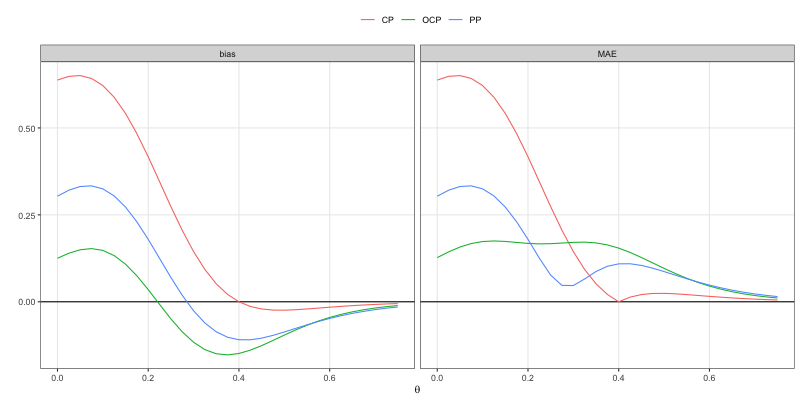

RObject{VecSxp}


In [17]:
# reuse the sample for smoothness
smpl = rand(Normal(0, 1), 1000)

function sim(θ, m)
    zm     = smpl .+ √(m)*θ
    truecp = CP.(zm, n, m, crit, θ)
     CP_ = mean(abs.(CP.(zm, n, m, crit, 0.4) .- truecp))
    OCP_ = mean(abs.(OCP.(zm, n, m, crit) .- truecp))
     PP_ = mean(abs.(PP.(zm, n, m, crit, φ) .- truecp))
    CP_, OCP_, PP_
end

θ = 0:0.025:0.75

res = [sim(θ, m) for θ in θ]
res = transpose(hcat([[a...] for a in res]...))
tbl_mae = DataFrame(
    theta = θ,
       CP = res[:,1],
      OCP = res[:,2],
       PP = res[:,3]
)

function sim(θ, m)
    zm     = smpl .+ √(m)*θ
    truecp = CP.(zm, n, m, crit, θ)
     CP_ = mean(CP.(zm, n, m, crit, 0.4) .- truecp)
    OCP_ = mean(OCP.(zm, n, m, crit) .- truecp)
    PP_ = mean(PP.(zm, n, m, crit, φ) .- truecp)
    CP_, OCP_, PP_
end

res = [sim(θ, m) for θ in θ]
res = transpose(hcat([[a...] for a in res]...))
tbl_bias = DataFrame(
    theta = θ,
       CP = res[:,1],
      OCP = res[:,2],
       PP = res[:,3]
)

R"
bind_rows(
        mutate($tbl_mae, quantity = 'MAE'),
        mutate($tbl_bias, quantity = 'bias')
    ) %>%
    pivot_longer(-c(theta, quantity)) %>%
    ggplot() +
        aes(theta, value, color = name) +
        geom_hline(yintercept = 0) +
        geom_line() +
        facet_wrap(~quantity) +
        labs(x = expression(theta), y = '', color = '') +
        theme_bw() + 
        theme(
            legend.position = 'top',
            panel.grid.minor = element_blank()
        )
"

Clearly, the high sensitivity of OCP leads to a high but consistent MAE as cmpared to CP, which is very good close to the assumed parameter value but very bad for much smaller true values of $\theta$. Again,the Bayesian PP compromise between these extremes based on the properties of the prior.
Note that the MAE of CP is better than that of OCP for a quite wide range of parameter valeus around the assumed $\theta=0.4$.

In terms of  maximal absolute bias, OCP is best, but in the relevant region even weak prior or a vague prior with wrong mean performs best. Reasons:
* CP, OCP, PP can be seen as estomators of unknown $\CP(z_m, \crit, \theta)$
* typically $m<<n$ will be small since a late change of sample size has little effect
* estmating $\theta$ is already hard after observing $n$ since the sample size is usually derived based on power arguments (80%/90%) and deciding weather or not to reject the null hypthesis is an easier problem than estimating the underlying parameter precisely
* $m<<n$ then means that the evidence on the magintude of $\theta$ during an early interim ins very sparse, i.e., the estimaton problem is even harder than at the end of the study
* the estimation problem can be stabilised using some form of regularistion and that is exactly what PP does via the Bayesian prior

## Sampling distribution of CP, OCP, PP

In [18]:
function sim(θ)
    zm   = smpl .+ √(m)*θ
     CP_ = CP.(zm, n, m, crit, 0.4)
    OCP_ = OCP.(zm, n, m, crit)
     PP_ = PP.(zm, n, m, crit, φ)
   cPoS_ = cPoS.(zm, n, m, crit, φ)
     tbl = convert(DataFrame, [zeros(1000) .+ θ CP_ OCP_ PP_ cPoS_])
    rename!(tbl, [:theta, :CP, :OCP, :PP, :cPoS])
end

sim (generic function with 2 methods)

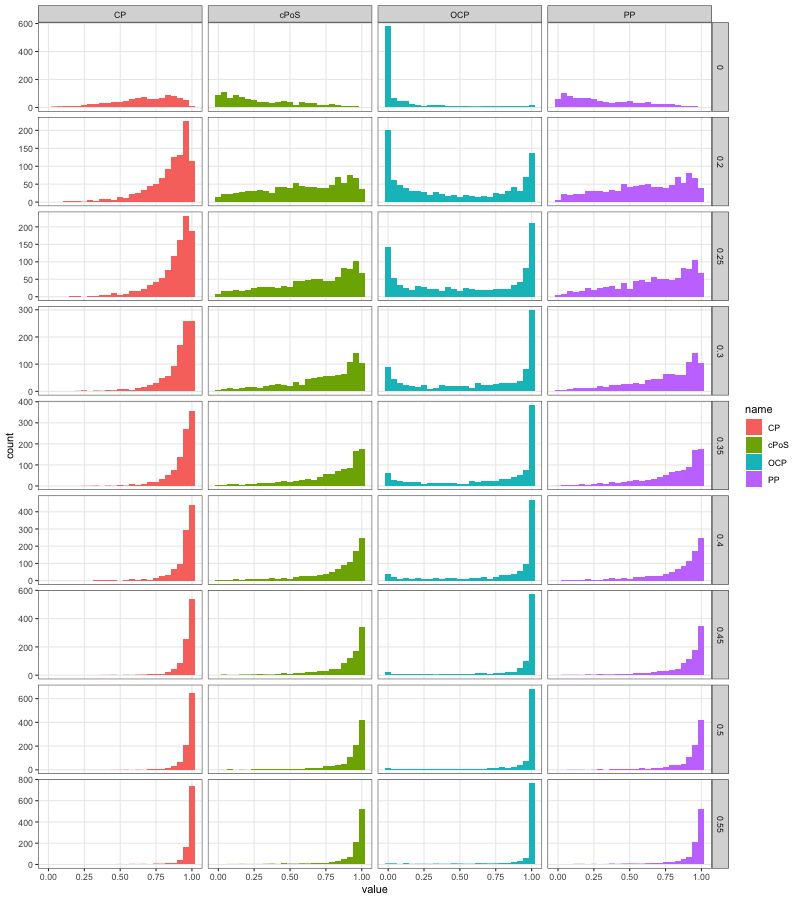

RObject{VecSxp}


In [19]:
tbl_sim = [sim(θ) for θ in vcat(0, 0.2:0.05:0.55)] |> 
    x -> vcat(x...)

RCall.rcall_p(:options, rcalljl_options=Dict(:width => 800, :height => 900))
R"
$tbl_sim %>%
    pivot_longer(-theta) %>%
    ggplot() +
        aes(value, fill = name) +
        geom_histogram(bins = 25, position = 'identity') + 
        facet_grid(theta ~ name, scales = 'free_y') +
        theme_bw() +
        theme(
            panel.grid.minor = element_blank()
        )
"

In [20]:
RCall.rcall_p(:options, rcalljl_options=Dict(:width => 800, :height => 400))

Ptr{VecSxp} @0x00007fdfa0b1fd98

Note that, for CP and PP estimate $\CP(z_m, \crit, \theta)$ *conditonal* on $\theta\geq 0$. 
This is consistent with their use in sample size recalculation since it is only sensible to recalculate the sample size under the assumption of a positive effct. OCP on the other hand does not conditon on the existance of a positve effect (if $z_m$ is negative). 
It is thus better suited to estimate the probability of rejecting the null hypothesis. 
If that is indeed the goal, one could also just use the marginal Bayesian probability of rejecting the null. 
Note, however, that such an unconditional quantity should NOT be used to reassess sample size!

cPoS addresses neither of these issues sice it is unconditional but restricted to $\Theta>0$. 

## Back to example: recalculation?

This unplanned interim analysis could have two of the following goals:

1. Adjust the final sample size to $n'<n_{max}$ such that the probability of rejecting the null at the end of the trial given the data observed so far is sufficiently large without violating strict type one error rate control.
2. Assess the prospects of reaching the study goal after recruiting all $n'$ individuals and stop the trial for futility if the chances are too small. Early futility stopping never incurs a type one error rate penalty!

The first problem can be addressed by solving

\begin{align}
    \operatorname{argmin}(n', c') \quad & n' \\
    \text{ subject to} \quad & \PP_{n'}(z_m, c') \geq 1 - \beta \\
                      &  \CP_{n'}(z_m, c', 0) \leq \CP(z_m, \crit, 0) \\
                      &  m <= n'_{min} \leq n' \leq n_{max} \ . 
\end{align}

Here, the first condition ensures that *the probability of rejecting the null at the end of the trial given the data observed so far is sufficiently large* while the second condition ensures type one error rate control via the conditional error principle and the third ensures that the upper sample size boundary is respected (and we don't go back in time). 
The lower boundary $n'_{min}$ is set to ensure a minimal sample size for the remaining study (otherwise operation costs not justified).

Note that the formulation in 1. naturally leads to the use of predictive power, conditional power is only used to evaluate the conditional type one error rate since this is not affected by uncertainty.

Note that, when the lower boundary is hit, the critical value is not identifieable from the above given formulation. In that case we just $\CP_{n_min}(z_m, c', 0) = \CP(z_m, \crit, 0)$ for the given sample $n_min$ size to obtain the adjusted critical value.

Assume that $n'_{min} = 30, n_{max} = 160$ and $1-\beta=0.8$.


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************



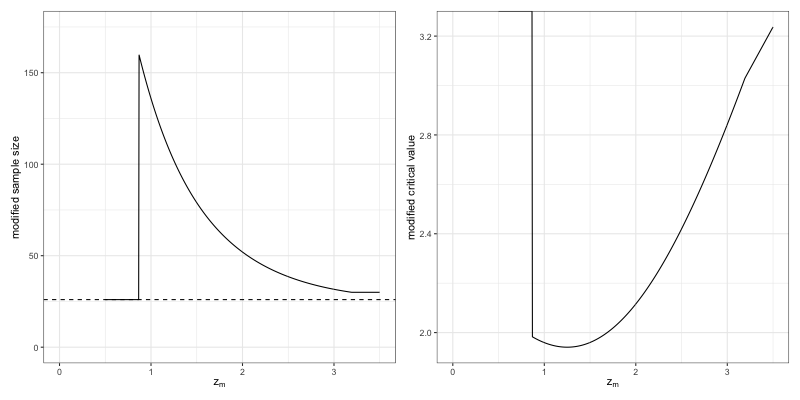

RObject{VecSxp}


In [21]:
n_min = 30
n_max = 160
    β = 0.2

function adapt(zm, n_min, n_max, threshold, prior)
    α′ = CP(zm, n, m, crit, 0.0)
    mdl = Model(optimizer_with_attributes(Ipopt.Optimizer, "max_cpu_time" => 60.0, "print_level" => 0))
    # pretty sensitive to starting values
    @variable(mdl, 0.8*crit <= crit′<= 2*crit, start = crit)
    @variable(mdl, n_min <= n′ <= n_max, start = max(m + 2, n/zm))
    @objective(mdl, Min, n′)
    cp_(n′, crit′) = CP(zm, n′, m, crit′, 0.0)
    register(mdl, :cp_, 2, cp_; autodiff = true)
    pp_(n′, crit′) = PP(zm, n′, m, crit′, prior)
    register(mdl, :pp_, 2, pp_; autodiff = true)
    @NLconstraint(mdl , cp_(n′, crit′) <= cp_(n, crit))
    @NLconstraint(mdl , pp_(n′, crit′) >= threshold)
    optimize!(mdl)
    if Int(termination_status(mdl)) == 4
        res = [value(n′), value(crit′)] 
    else
        if zm > 3
            return [n_min, -Inf]
        else
            return [m, Inf]
        end
    end
    if round(res[1]) == n_min # hit lower bound, refit with conditional error equality to get critical value
        mdl = Model(optimizer_with_attributes(Ipopt.Optimizer, "max_cpu_time" => 60.0, "print_level" => 0))
        @variable(mdl, crit <= crit′ <= crit + zm/2, start = crit)
        register(mdl, :cp_, 2, cp_; autodiff = true)
        @NLconstraint(mdl , cp_(res[1], crit′) == cp_(n, crit))
        optimize!(mdl)
        res[2] = value(crit′)
    end
    return res
end

         zm = 0.5:0.005:3.5
        res = hcat(zm, hcat(adapt.(zm, n_min, n_max, 1 - β, φ)...)')
        res = res[.!isnan.(res[:, 2]), :]
tbl_adapted = convert(DataFrame, res)
rename!(tbl_adapted, [:zm, :nprime, :cprime])

R"
plt1 <- ggplot($tbl_adapted) +
    aes(zm, nprime) +
    geom_line() +
    geom_hline(yintercept = 26, linetype = 2) + 
    scale_x_continuous(expression(z[m]), limits = c(0, 3.5)) +
    scale_y_continuous('modified sample size', limits = c(0, 175)) +
    theme_bw()
plt2 <- ggplot($tbl_adapted) +
    aes(zm, cprime) +
    geom_line() +
    scale_x_continuous(expression(z[m]), limits = c(0, 3.5)) +
    scale_y_continuous('modified critical value') +
    theme_bw()
plt1 + plt2
"

The maximal sample size clearly implies a futility boundary since the criterion would not allow continuation with more than 80% predictive power within the set maximum of 160 subjects. 

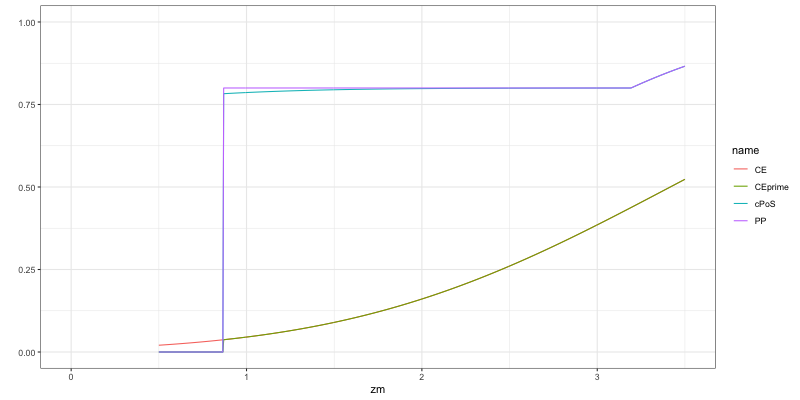

RObject{VecSxp}


In [22]:
tbl_adapted[:, :cPoS] = cPoS.(tbl_adapted[:, :zm], tbl_adapted[:, :nprime], m, tbl_adapted[:, :cprime], φ)
tbl_adapted[:, :PP] = PP.(tbl_adapted[:, :zm], tbl_adapted[:, :nprime], m, tbl_adapted[:, :cprime], φ)
tbl_adapted[:, :CEprime] = CP.(tbl_adapted[:, :zm], tbl_adapted[:, :nprime], m, tbl_adapted[:, :cprime], 0.0)
tbl_adapted[:, :CE] = CP.(tbl_adapted[:, :zm], n, m, crit, 0.0)
tbl_adapted

R"
$tbl_adapted %>%
    select(zm, cPoS, PP, CEprime, CE) %>%
    pivot_longer(-zm, names_to = 'name', values_to = 'value') %>%
    ggplot() +
        aes(zm, value, color = name) +
        geom_line() +
        scale_x_continuous('zm', limits = c(0, 3.5)) +
        scale_y_continuous('', limits = c(0, 1)) +
        theme_bw()
"

Since the prior is relatively optimistic, $\PoS(\crit\cond z_m)\approx\PP(z_m, \crit)$ and the futility stopping does not need to be modified. I.e., the maximal sample size constraint is more restrictive than say $\PoS(\crit\cond z_m)\geq 0.7$.
Since $\PoS(\crit\cond z_m)\leq\PP(z_m, \crit)$ and the predictive power was set to 80\% a harder constraint on $\PoS(\crit\cond z_m)$ would not make sense!

## Properties of the binding recalculation design


In [24]:
marginal_pdf(zm, m, prior) = integrate(θ -> pdf.(Normal(√(m).*θ), zm) .* prior.(θ)) 

function cmarginal_pdf(zm, m, prior) 
    # condition prior on effect > 0
    normalizing_constant = integrate(prior, 0)
               cprior(θ) = prior(θ) / normalizing_constant
    integrate(θ -> pdf(Normal(√(m)*θ, 1), zm) * cprior(θ), 0)
end

# define interval to integrate
cfut = tbl_adapted[findlast(tbl_adapted[:, :cprime] .== Inf) + 1, :zm]
ceff = tbl_adapted[findfirst(tbl_adapted[:, :nprime] .== n_min) - 1, :zm]
prfut = 1 - integrate(zm -> marginal_pdf(zm, m, φ), cfut)
preff = integrate(zm -> marginal_pdf(zm, m, φ), ceff)

ess = integrate(zm -> marginal_pdf(zm, m, φ) .* adapt(zm, n_min, n_max, 1 - β, φ)[1], cfut, ceff) + 
    prfut * m + 
    preff * n_min

toer = integrate(
        zm -> pdf.(Normal(), zm) .* 
            CP(zm, adapt(zm, n_min, n_max, 1 - β, φ)[1], m, adapt(zm, n_min, n_max, 1 - β, φ)[2], 0), 
        cfut
    )

ep1 = integrate(
        zm -> cmarginal_pdf(zm, m, φ) .* 
            PP(zm, adapt(zm, n_min, n_max, 1 - β, φ)[1], m, adapt(zm, n_min, n_max, 1 - β, φ)[2], φ), 
        cfut, ceff
    )
ep2 = integrate(
        zm -> cmarginal_pdf(zm, m, φ) .* 
            PP(zm, adapt(zm, n_min, n_max, 1 - β, φ)[1], m, adapt(zm, n_min, n_max, 1 - β, φ)[2], φ), 
        ceff, 15
    )
ep = ep1 + ep2

@show ess, toer, ep

(ess, toer, ep) = (48.25488124127254, 0.017787737139843204, 0.672026784578603)


(48.25488124127254, 0.017787737139843204, 0.672026784578603)

Clearly, if one were to make this naive approach binding, the expected sample size is much smaller than before but also the mTOER is reduced and the expected power is lower than the initially planned 80%. I.e., the test does not have much in common with the original design goals.
There are certainly ways to fix this (e.g. the 'missing' $\alpha$ could be redistributed, never reducing original sample size etc.) but practical hacks do not address the underlying flaws of the approach. 
An analytical approach of deriving an optimal adaptation function for a particular setting is described in [Optimal Conditional Error Functions for the Control of Conditional Power].
A generalisation via the variational perspective was given in [A variational approach to optimal two‐stage designs] and [JSS].

Note that although the authors in [Optimal Conditional Error Functions for the Control of Conditional Power] start with methods from unplanned adaptations, they essentially end up solving the problem

\begin{align}
    \operatorname{argmin}(m, n(\cdot), c(\cdot)) \quad & \operatorname{E}[\,n(z_m)\,] \\
    \text{ subject to} \quad 
        & \Pr_{0}[\,Z_{n(Z_m)} > c(Z_m)\,] \leq \alpha \\
        & \Pr[\,Z_{n(Z_m)} > c(Z_m)\cond\Theta > 0 \,] \geq 1 - \beta \\
        & \PP(z_m, c(z_m)) \geq 1 - \beta_c \ .
\end{align}

This is an unconditional problem with additional condition constraint [biostats paper, JSS]. 
Further note, that the objective criterion is necessarily different than for the single-stage design where one could simply minimize the sample size. 
For two-stage designs, the sample size is a (usually) deterministic function of the observed effect at the interim analysis, $n(Z_m)$, and thus a random variable.
As such, only a function of its distribution can be minimized.
Another way of seeing this is that for single-stage designs all sensible functionals of the sample size 'distribution' equal $n$ itself. 

This means, that although the optimal design might exhibit lower expected sample size, the variability of the sample size will generally be higher. 
Of course, the formulation here implicitly limits the number of pre=planned interim analyses to 1, but the same principle could be applied to multiple interim analyses.
It is well known that the returns of more interim analyses are diminishing quickly though [???] and we focus on the 0 vs 1 interim analyses comparison to simplify notation.
Trivially, a single-stage design is optimal when minimising $\operatorname{E}[\,n(Z_m)\,]$ under the additional constraint that $\operatorname{V}[\,n(Z_m)\,]=0$, i.e.

\begin{align}
    \operatorname{argmin}(m, n(\cdot), c(\cdot)) \quad & \operatorname{E}[\,n(z_m)\,] \\
    \text{ subject to} \quad 
        & \Pr_{0}[\,Z_{n(Z_m)} > c(Z_m)\,] \leq \alpha \\
        & \Pr[\,Z_{n(Z_m)} > c(Z_m)\cond\Theta > 0 \,] \geq 1 - \beta \\
        & \operatorname{V}[\,n(Z_m)\,]=0 \ .
\end{align}

leads to the single stage designs discussed earlier.
This can be seen as a nested optimisation approach where one first finds the design with minimal expected sample size given an acceptable variance of the sample size and then minimizes that acceptable variance. 
A comparison between the single stage design and the 'optimal adaptive' one derived via problem xxx-yyy is thus not fair since they optimize different objectives.
In practice, it would probably be better to penalise the variability of the sample size via an expected cost functional since procurement of drug doses might be more expensive depending on how variable the sample size is. 

A fair comparison would instead consider the optimal two-stage design derived from 

\begin{align}
    \operatorname{argmin}(m, n(\cdot), c(\cdot)) \quad & \operatorname{E}[\,n(z_m)\,] \\
    \text{ subject to} \quad 
        & \Pr_{0}[\,Z_{n(Z_m)} > c(Z_m)\,] = \alpha \\
        & \Pr[\,Z_{n(Z_m)} > c(Z_m)\cond\Theta > 0 \,] = 1 - \beta \\
        & \PP(z_m, c(z_m)) = 1 - \beta_c \\
        & \operatorname{V}[\,n(Z_m)\,]=0 \ .
\end{align}

However, $\PP(z_m, c(z_m)) = 1 - \beta_c$ and $\operatorname{V}[\,n(Z_m)\,]=0$ cannot be fulfilled at the same time whenever $1-\beta_c>0$.
This follows from $ \operatorname{V}[\,n(Z_m)\,]=0 \Rightarrow n(\cdot), c(\cdot) = n', c'$ but then $\lim_{z_m\to0}PP_{n'}(z_m, c')=0$ and
thus $\PP(z_m, c') = 1 - \beta_c$ cannot hold for all $z_m$.

This raises the question as to why one would want to include the constraint $\PP(z_m, c(z_m))= 1 - \beta_c$ in the first place. 
It is clearly not necessary from a regulatory perspective and, when binding, will only increase the objective criterion due to the smaller feasible space.
There is also the question of how to choose $1-\beta_c$.
[link to fishers exact test?]

The minimal conditional power constraint can also be critizised from the perspective of unplanned adaptations.
Going back to the 'ad-hoc adaptation' discussed earlier, 
it is clear that there is an assymetry with respect to how type-one and type-two error rates conditional on $Z_m=z_m$ are handled.
For the conditional type one error rate, the conditional error principle is invoked to ensure that the overall error level is not inflated. 
For the predictive power (conditional type two error rate) however an arbitrary fixed threshold is used. 
Interestingly, if one were to apply the conditional error principle to PP as well, the original design would be invariant under recalculation at any $1\leq m < n$ since the original $(n, \crit)$ satisfies all constraints and the constraints already determine $(n', c')$ uniquely

$$
\PP(z_m, c) = \PP(z_m, \crit) \text{ and } \CP(z_m, c, 0) = \CP(z_m, \crit, 0) \text{ and } n'_{min} \leq n' \leq n_{max}, m < n'_{min} \ .
$$

How can this conditional 'adaptation' be justified in terms of a global optimisation problem? Well, in essence, we are seeking constant functions $n(z_m)=n$ and $c(z_m)=c$ that solve the problem

\begin{align}
    \operatorname{argmin}(m, n(\cdot), c(\cdot)) \quad & \operatorname{E}[\,n(z_m)\,] \\
    \text{ subject to} \quad 
        & \Pr_{0}[\,Z_{n(Z_m)} > c(Z_m)\,] \leq \alpha \\
        & \Pr[\,Z_{n(Z_m)} > c(Z_m)\cond\Theta > 0 \,] \geq 1 - \beta \\
        & \big(\,\operatorname{V}[\,n(Z_m)\,]=0\, \big) \ .
\end{align}

or equivalently 

\begin{align}
    \operatorname{argmin}(n, c) \quad & n \\
    \text{ subject to} \quad 
        & \Pr_{0}[\,Z_{n} > c\,] \leq \alpha \\
        & \Pr[\,Z_{n} > c \cond\Theta > 0 \,] \geq 1 - \beta \ .
\end{align}

The constraints alone uniquely define the solution. 
The solution $(n^*,c^*)$ implicitly defines a unique conditional error function $z_m \mapsto \Pr_{0}[\,Z_{n^*} > c^* \cond Z_m = z_m\,]$ and a unique conditional predictive power function $z_m \mapsto \Pr[\,Z_{n^*} > c^* \cond \Theta > 0, Z_m = z_m\,]$.
The conditional error principle then stipulates that it is a sufficient condition to match these in order to maintain the overall unconditional error rates despite a data-dependent adaptation [intuitively that should work, did not prove it for the 'hybrid' version of PP].
This is exactly what equations ??? do.
Put differently, the implicit choice of objective function (expected sampe size conditional on zero variability) trivially forbids any change of the sample size and thus any unplanned adaptation based on the observed $z_m$ alone. 
In other words, when treating the type one and type two error rates equally with respect to the conditional error principle, the original
design is invariant under unplanned recalculation.

However, nothing prevents us from changing the objective mid-trial. If we drop the $\operatorname{V}[\,n(Z_m)\,]=0$ constraint mid trial, the original sample size can become variable (ref to optimal design).
Since we started with a single stage designs (because the constraint was in place during planning), we are still bound to the same error rate constraints andt the conditional error principle (maintain unconditional mTOER and minimal expected power) again leads to the same (conditional) problem and the design would still not change.

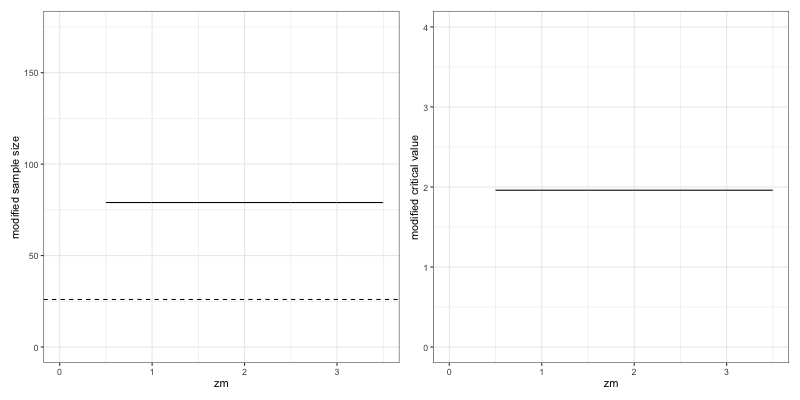

RObject{VecSxp}


In [25]:
function adapt2(zm, n_min, n_max, prior)
    α′ = CP(zm, n, m, crit, 0.0)
    β′ = 1 - PP(zm, n, m, crit, prior)
    mdl = Model(optimizer_with_attributes(Ipopt.Optimizer, "max_cpu_time" => 60.0, "print_level" => 0))
    # pretty sensitive to starting values
    @variable(mdl, 0.8*crit <= crit′<= 2*crit, start = crit)
    @variable(mdl, n_min <= n′ <= n_max, start = max(m + 2, n/zm))
    @objective(mdl, Min, n′)
    cp_(n′, crit′) = CP(zm, n′, m, crit′, 0.0)
    register(mdl, :cp_, 2, cp_; autodiff = true)
    pp_(n′, crit′) = PP(zm, n′, m, crit′, prior)
    register(mdl, :pp_, 2, pp_; autodiff = true)
    @NLconstraint(mdl , cp_(n′, crit′) <= cp_(n, crit))
    @NLconstraint(mdl , pp_(n′, crit′) >= 1 - β′)
    optimize!(mdl)
    if Int(termination_status(mdl)) == 4
        res = [value(n′), value(crit′)] 
    else
        if zm > 3
            return [n_min, -Inf]
        else
            return [m, Inf]
        end
    end
    if round(res[1]) == n_min # hit lower bound, refit with conditional error equality to get critical value
        mdl = Model(optimizer_with_attributes(Ipopt.Optimizer, "max_cpu_time" => 60.0, "print_level" => 0))
        @variable(mdl, crit <= crit′ <= crit + zm/2, start = crit)
        register(mdl, :cp_, 2, cp_; autodiff = true)
        @NLconstraint(mdl , cp_(res[1], crit′) == cp_(n, crit))
        optimize!(mdl)
        res[2] = value(crit′)
    end
    return res
end

         res = hcat(zm, hcat(adapt2.(zm, n_min, n_max, φ)...)')
         res = res[.!isnan.(res[:, 2]), :]
tbl_adapted2 = convert(DataFrame, res)
rename!(tbl_adapted2, [:zm, :nprime, :cprime])

R"
plt1 <- ggplot($tbl_adapted2) +
    aes(zm, nprime) +
    geom_line() +
    geom_hline(yintercept = 26, linetype = 2) + 
    scale_x_continuous('zm', limits = c(0, 3.5)) +
    scale_y_continuous('modified sample size', limits = c(0, 175)) +
    theme_bw()
plt2 <- ggplot($tbl_adapted2) +
    aes(zm, cprime) +
    geom_line() +
    scale_x_continuous('zm', limits = c(0, 3.5)) +
    scale_y_continuous('modified critical value', limits = c(0, 4)) +
    theme_bw()
library(patchwork)
plt1 + plt2
"

So, when does a sample size adaptation make sense then? 
Well, recall that the original problem also depends on the prior $\varphi$. 
If we changed $\varphi$ to $\psi$ mid-trial we would like to 

1. maintain strict type one error rate control
2. maintain the same chances of detecting an effect under the new prior given the data as we had planned for under the old prior
3. do 1 + 2 with minimal expected sample size.

This leads to the conditional problem 

\begin{align}
    \operatorname{argmin}(n', c') \quad & n' \\
    \text{ subject to} \quad 
        & \Pr_{0}[\,Z_{n'} > c'\,] \leq \Pr_{0}[\,Z_{n} > c\,] \\
        & \Pr_\psi[\,Z_{n'} > c' \cond \Theta > 0 \,] \geq \Pr_\varphi[\,Z_{n} > c \cond \Theta > 0 \,]  \ .
\end{align}

The interesting modification is the constraint $\Pr_\psi[\,Z_{n'} > c' \cond \Theta > 0 \,] \geq \Pr_\varphi[\,Z_{n} > c \cond \Theta > 0 \,]$ which addresses 2.
Since the prior on the left hand side is different, the original $(n, c)$ the constraint will in general no longer hold with equality and the sample size will have to be adjusted. 

[this is what I conjured up, not sure I already hit home here. The crucial question is: how do you map the original unconditional power constraint to the conditional situation? I oppose $PP > 1-beta_c$ because 1) it treats type one and type two error rates fundamentally different and 2) the original design would not be invariant under no prior change! Esp. the latter one should be a core criterion for any adaptive design modification!]

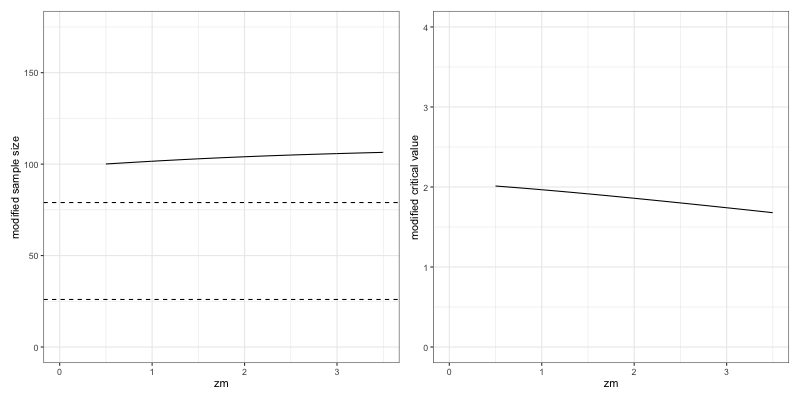

RObject{VecSxp}


In [26]:
function adapt3(zm, n_min, n_max, priorold, priornew)
    α′ = CP(zm, n, m, crit, 0.0)
    β′ = 1 - PP(zm, n, m, crit, priorold)
    mdl = Model(optimizer_with_attributes(Ipopt.Optimizer, "max_cpu_time" => 60.0, "print_level" => 0))
    # pretty sensitive to starting values
    @variable(mdl, 0.8*crit <= crit′<= 2*crit, start = crit)
    @variable(mdl, n_min <= n′ <= n_max, start = max(m + 2, n/zm))
    @objective(mdl, Min, n′)
    cp_(n′, crit′) = CP(zm, n′, m, crit′, 0.0)
    register(mdl, :cp_, 2, cp_; autodiff = true)
    pp_(n′, crit′) = PP(zm, n′, m, crit′, priornew)
    register(mdl, :pp_, 2, pp_; autodiff = true)
    @NLconstraint(mdl , cp_(n′, crit′) <= cp_(n, crit))
    @NLconstraint(mdl , pp_(n′, crit′) >= 1 - β′)
    optimize!(mdl)
    if Int(termination_status(mdl)) == 4
        res = [value(n′), value(crit′)] 
    else
        if zm > 3
            return [n_min, -Inf]
        else
            return [m, Inf]
        end
    end
    if round(res[1]) == n_min # hit lower bound, refit with conditional error equality to get critical value
        mdl = Model(optimizer_with_attributes(Ipopt.Optimizer, "max_cpu_time" => 60.0, "print_level" => 0))
        @variable(mdl, crit <= crit′ <= crit + zm/2, start = crit)
        register(mdl, :cp_, 2, cp_; autodiff = true)
        @NLconstraint(mdl , cp_(res[1], crit′) == cp_(n, crit))
        optimize!(mdl)
        res[2] = value(crit′)
    end
    return res
end

ψ(θ) = pdf(Normal(0.3, 0.2), θ)

 res = hcat(zm, hcat(adapt3.(zm, n_min, n_max, φ, ψ)...)')
         res = res[.!isnan.(res[:, 2]), :]
tbl_adapted3 = convert(DataFrame, res)
rename!(tbl_adapted3, [:zm, :nprime, :cprime])

R"
plt1 <- ggplot($tbl_adapted3) +
    aes(zm, nprime) +
    geom_line() +
    geom_hline(yintercept = 26, linetype = 2) + 
    geom_hline(yintercept = 79, linetype = 2) + 
    scale_x_continuous('zm', limits = c(0, 3.5)) +
    scale_y_continuous('modified sample size', limits = c(0, 175)) +
    theme_bw()
plt2 <- ggplot($tbl_adapted3) +
    aes(zm, cprime) +
    geom_line() +
    scale_x_continuous('zm', limits = c(0, 3.5)) +
    scale_y_continuous('modified critical value', limits = c(0, 4)) +
    theme_bw()
plt1 + plt2
"

This is actually the wrong way of looking at it. The plot treats $z_m$ as variable and the prior mean as fixed; it is the other way around though!

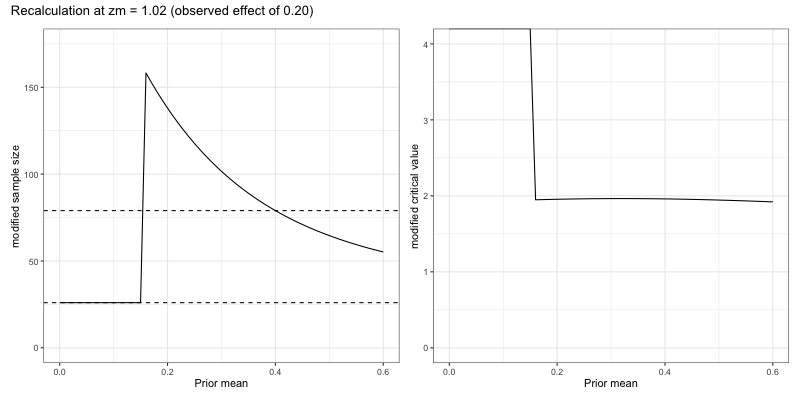

RObject{VecSxp}


In [39]:
function adapt4(zm, n_min, n_max, priorold, priornewmean)
    α′ = CP(zm, n, m, crit, 0.0)
    β′ = 1 - PP(zm, n, m, crit, priorold)
    mdl = Model(optimizer_with_attributes(Ipopt.Optimizer, "max_cpu_time" => 60.0, "print_level" => 0))
    # pretty sensitive to starting values
    @variable(mdl, 0.8*crit <= crit′<= 2*crit, start = crit)
    @variable(mdl, n_min <= n′ <= n_max, start = max(m + 2, n/zm))
    @objective(mdl, Min, n′)
    cp_(n′, crit′) = CP(zm, n′, m, crit′, 0.0)
    register(mdl, :cp_, 2, cp_; autodiff = true)
    pp_(n′, crit′) = PP(zm, n′, m, crit′, θ -> pdf(Normal(priornewmean, 0.2), θ))
    register(mdl, :pp_, 2, pp_; autodiff = true)
    @NLconstraint(mdl , cp_(n′, crit′) <= cp_(n, crit))
    @NLconstraint(mdl , pp_(n′, crit′) >= 1 - β′)
    optimize!(mdl)
    if Int(termination_status(mdl)) == 4
        res = [value(n′), value(crit′)] 
    else
        if zm > 3
            return [n_min, -Inf]
        else
            return [m, Inf]
        end
    end
    if round(res[1]) == n_min # hit lower bound, refit with conditional error equality to get critical value
        mdl = Model(optimizer_with_attributes(Ipopt.Optimizer, "max_cpu_time" => 60.0, "print_level" => 0))
        @variable(mdl, crit <= crit′ <= crit + zm/2, start = crit)
        register(mdl, :cp_, 2, cp_; autodiff = true)
        @NLconstraint(mdl , cp_(res[1], crit′) == cp_(n, crit))
        optimize!(mdl)
        res[2] = value(crit′)
    end
    return res
end

         res = hcat(0:0.01:0.6, hcat(adapt4.(sqrt(m)*0.2, n_min, n_max, φ, 0:0.01:0.6)...)')
         res = res[.!isnan.(res[:, 2]), :]
tbl_adapted4 = convert(DataFrame, res)
rename!(tbl_adapted4, [:priormean, :nprime, :cprime])

R"
plt1 <- ggplot($tbl_adapted4) +
    aes(priormean, nprime) +
    geom_line() +
    geom_hline(yintercept = 26, linetype = 2) + 
    geom_hline(yintercept = 79, linetype = 2) + 
    scale_x_continuous('Prior mean') +
    scale_y_continuous('modified sample size', limits = c(0, 175)) +
    theme_bw()
plt2 <- ggplot($tbl_adapted4) +
    aes(priormean, cprime) +
    geom_line() +
    scale_x_continuous('Prior mean') +
    scale_y_continuous('modified critical value', limits = c(0, 4)) +
    theme_bw()
plt1 + plt2 + plot_annotation(
    title = sprintf('Recalculation at zm = %.2f (observed effect of %.2f) ', sqrt(26)*0.2, 0.2)
)
"

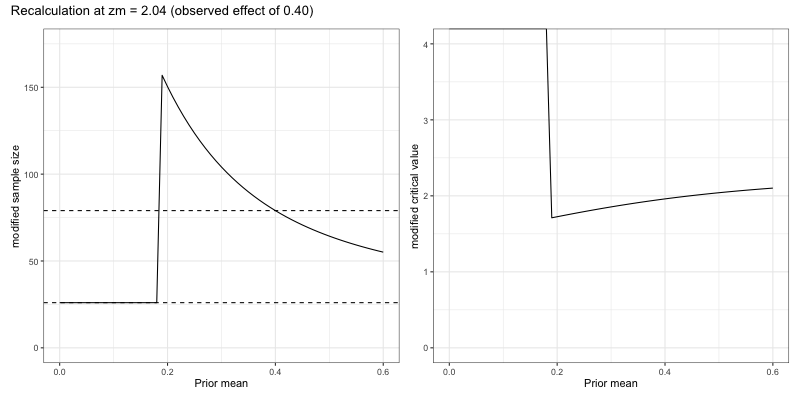

RObject{VecSxp}


In [42]:
         res = hcat(0:0.01:0.6, hcat(adapt4.(sqrt(26)*0.4, n_min, n_max, φ, 0:0.01:0.6)...)')
         res = res[.!isnan.(res[:, 2]), :]
tbl_adapted5 = convert(DataFrame, res)
rename!(tbl_adapted5, [:priormean, :nprime, :cprime])

R"
plt1 <- ggplot($tbl_adapted5) +
    aes(priormean, nprime) +
    geom_line() +
    geom_hline(yintercept = 26, linetype = 2) + 
    geom_hline(yintercept = 79, linetype = 2) + 
    scale_x_continuous('Prior mean') +
    scale_y_continuous('modified sample size', limits = c(0, 175)) +
    theme_bw()
plt2 <- ggplot($tbl_adapted5) +
    aes(priormean, cprime) +
    geom_line() +
    scale_x_continuous('Prior mean') +
    scale_y_continuous('modified critical value', limits = c(0, 4)) +
    theme_bw()
plt1 + plt2 + plot_annotation(
    title = sprintf('Recalculation at zm = %.2f (observed effect of %.2f) ', sqrt(26)*0.4, 0.4)
)
"

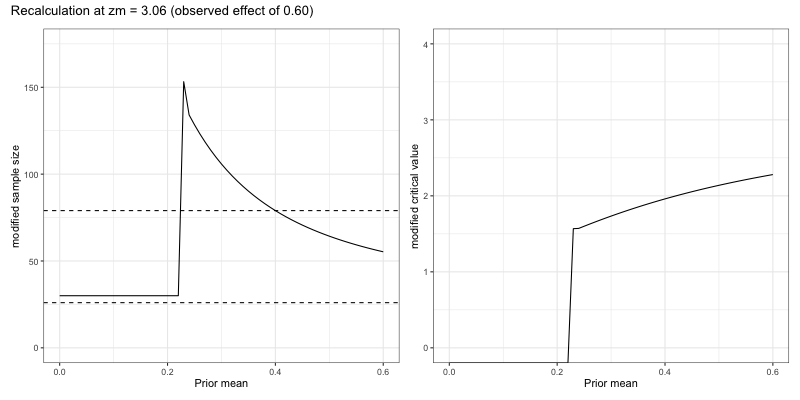

RObject{VecSxp}


In [43]:
         res = hcat(0:0.01:0.6, hcat(adapt4.(sqrt(26)*0.6, n_min, n_max, φ, 0:0.01:0.6)...)')
         res = res[.!isnan.(res[:, 2]), :]
tbl_adapted6 = convert(DataFrame, res)
rename!(tbl_adapted6, [:priormean, :nprime, :cprime])

R"
plt1 <- ggplot($tbl_adapted6) +
    aes(priormean, nprime) +
    geom_line() +
    geom_hline(yintercept = 26, linetype = 2) + 
    geom_hline(yintercept = 79, linetype = 2) + 
    scale_x_continuous('Prior mean') +
    scale_y_continuous('modified sample size', limits = c(0, 175)) +
    theme_bw()
plt2 <- ggplot($tbl_adapted6) +
    aes(priormean, cprime) +
    geom_line() +
    scale_x_continuous('Prior mean') +
    scale_y_continuous('modified critical value', limits = c(0, 4)) +
    theme_bw()
plt1 + plt2 + plot_annotation(
    title = sprintf('Recalculation at zm = %.2f (observed effect of %.2f) ', sqrt(26)*0.6, 0.6)
)
"

Clearly, at the original prior mean, the trial is invariant! [question, almost looks as if that was invariant to the zm that we condition on, probably because we just shift the prior]

### An alternative approach to localising the power constraint

The approach for adjusting the sample size to a change in the study-external information outline above crucially depends on criterion 2. for 'localising' the power constraint (i.e. apply the condiitonal error principle to type two error rates as well to derive a cnstraint for the PP).

The main challange lies in defining a conditional power constraint that is consistent with the original unconditional problem when the prior is unchanged [this, I feel, is the crucial point 'invariance principle' if it is violated you should have used a different design from the onset ;)].
An alternative approach is to avoid the constraint entirely by exploiting the duality between constraint minimisation and penalised optimisation.
I.e., for suitable $\lambda$ the original unconditional problem

\begin{align}
    \operatorname{argmin}(n, c) \quad & n \\
    \text{ subject to} \quad 
        & \Pr_{0}[\,Z_n > c\,] \leq \alpha \\
        & \Pr_\varphi[\,Z_n > c\cond\Theta > 0 \,] \geq 1 - \beta \ .
\end{align}

is equivalent to

\begin{align}
     \operatorname{argmin}(n, c) \quad & n - \lambda\,\Pr_\varphi[\,Z_n > c\cond\Theta > 0 \,]\\
    \text{ subject to} \quad 
        & \Pr_{0}[\,Z_n > c\,] \leq \alpha \ .
\end{align}

where $\lambda$ is the 'price of power' (memo: recalc, modulo sign etc.). 
If we then assume that $\lambda$ does not change, the conditional problem is simply 

\begin{align}
    \operatorname{argmin}(n', c') \quad & n' - \lambda\,\Pr_\psi[\,Z_{n'} > c'\cond Z_m = z_m, \Theta > 0 \,] \\
    \text{ subject to} \quad 
        & \Pr_{0}[\,Z_{n'} > c'\cond Z_m = z_m\,] \leq \Pr_{0}[\,Z_{n} > c\cond Z_m = z_m\,]   \ .
\end{align}

Should there be reason to adjust the 'price of power' to $\lambda'$ this can also be reflected by replacing $\lambda$ with $\lambda'$.
Again, the solution to the problem is trivially invariant if $\lambda$ and $\varphi$ remain unchanged, i.e., the reclaculation is consistent with the original design.

TODO: implement, get $\lambda$ elegantly via lagrange multiplier?

In [93]:
# step one identify λ
function get_n(λ)
    mdl =  Model(optimizer_with_attributes(Ipopt.Optimizer, "max_cpu_time" => 60.0, "print_level" => 0))
    @variable(mdl, 0 <= n′)
    function EP(n′) 
             norm = integrate(φ, 0)
        cprior(θ) = φ(θ)/norm
        integrate(θ -> (1 - cdf(Normal(√(n′)*θ, 1), crit)) * cprior(θ), 0)
    end
    register(mdl, :EP, 1, EP; autodiff = true)
    @NLobjective(mdl, Min, n′ - λ*EP(n′))
    optimize!(mdl)
    value(n′)
end

λ = collect(400:500)[findmin(abs.(get_n.(400:500) .- 79))[2]]
@show get_n(λ), λ

(get_n(λ), λ) = (78.9797902311222, 457)


(78.9797902311222, 457)

We can then set up the conditional optimisation problem using the original price $\lambda$

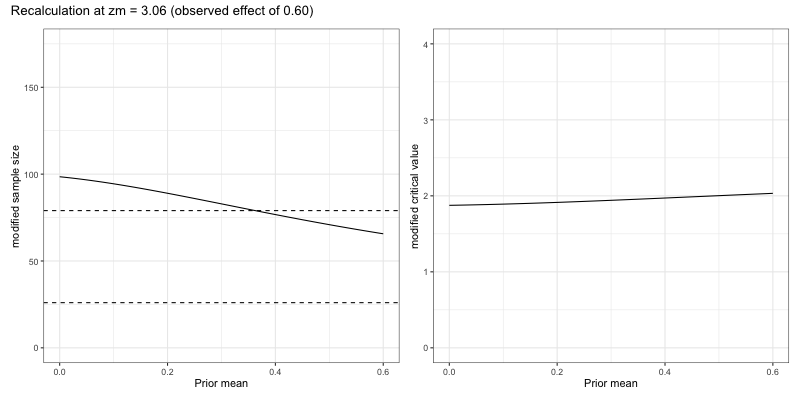

RObject{VecSxp}


In [97]:
function adapt5(zm, n_min, n_max, λ, priornewmean)
    α′ = CP(zm, n, m, crit, 0.0)
    mdl = Model(optimizer_with_attributes(Ipopt.Optimizer, "max_cpu_time" => 60.0, "print_level" => 0))
    # pretty sensitive to starting values
    @variable(mdl, 0.8*crit <= crit′<= 2*crit, start = crit)
    @variable(mdl, n_min <= n′ <= n_max, start = max(m + 2, n/zm))
    cp_(n′, crit′) = CP(zm, n′, m, crit′, 0.0)
    register(mdl, :cp_, 2, cp_; autodiff = true)
    pp_(n′, crit′) = PP(zm, n′, m, crit′, θ -> pdf(Normal(priornewmean, 0.2), θ))
    register(mdl, :pp_, 2, pp_; autodiff = true)
    @NLobjective(mdl, Min, n′ - λ*pp_(n′, crit′))
    @NLconstraint(mdl , cp_(n′, crit′) <= cp_(n, crit))
    optimize!(mdl)
    if Int(termination_status(mdl)) == 4
        res = [value(n′), value(crit′)] 
    else
        if zm > 3
            return [n_min, -Inf]
        else
            return [m, Inf]
        end
    end
    if round(res[1]) == n_min # hit lower bound, refit with conditional error equality to get critical value
        mdl = Model(optimizer_with_attributes(Ipopt.Optimizer, "max_cpu_time" => 60.0, "print_level" => 0))
        @variable(mdl, crit <= crit′ <= crit + zm/2, start = crit)
        register(mdl, :cp_, 2, cp_; autodiff = true)
        @NLconstraint(mdl , cp_(res[1], crit′) == cp_(n, crit))
        optimize!(mdl)
        res[2] = value(crit′)
    end
    return res
end

         res = hcat(0:0.01:0.6, hcat(adapt5.(sqrt(26)*0.4, n_min, n_max, λ, 0:0.01:0.6)...)')
         res = res[.!isnan.(res[:, 2]), :]
tbl_adapted7 = convert(DataFrame, res)
rename!(tbl_adapted7, [:priormean, :nprime, :cprime])

R"
plt1 <- ggplot($tbl_adapted7) +
    aes(priormean, nprime) +
    geom_line() +
    geom_hline(yintercept = 26, linetype = 2) + 
    geom_hline(yintercept = 79, linetype = 2) + 
    scale_x_continuous('Prior mean') +
    scale_y_continuous('modified sample size', limits = c(0, 175)) +
    theme_bw()
plt2 <- ggplot($tbl_adapted7) +
    aes(priormean, cprime) +
    geom_line() +
    scale_x_continuous('Prior mean') +
    scale_y_continuous('modified critical value', limits = c(0, 4)) +
    theme_bw()
plt1 + plt2 + plot_annotation(
    title = sprintf('Recalculation at zm = %.2f (observed effect of %.2f) ', sqrt(26)*0.4, 0.4)
)
"

Yipeeeh! that looks much more sensible, does it not. 

We don't even have to keep $\lambda$ fixed, can also be updated! Distinguishes between changes due to price/prior conviction. penalised minimisation generally less sensitve than a hard constraint; easier to explain?